In [1]:
import pandas as pd
import numpy as np
import gensim
import PyPDF2
from gensim.models import word2vec
import os

# import get_umls_concepts as umls

print('libraries imported')

libraries imported


##### Training Set and Concept Tags

A custom set of *one-gram* and *bi-gram* concept tags was created by me through filtering a combination of WHO's Health System Challenges and Health Focus Areas, in addition to our concept tags stored in Implementome's database. 

The objective being to find other terms (potential tags) which are the most relevant and similar to these tags using a cosine similarity measure between word vectors produced by the **word2vec** algorithm. After this modelling process is established, the next step should be to compare them to *MeSH* terms in order to produce more efficient and advanced queries for publications in PubMed, publications which will be used to create our custom training and testing sets that will be the inputs of our pre-trained Multi-Label Classification Model using *transformers*.

In [2]:
## our own tags
tags_df = pd.read_excel('data/all_tags_word2vec.xlsx')
tags_df

,One Word Tags,Bigram Tags (Med),Bigram Tags (Med) [Dash]
0,diagnostics,unplanned_pregnancy,unplanned-pregnancy
1,cybersecurity,patient_empowerment,patient-empowerment
2,who,world_health,world-health
3,infertility,risk_mitigation,risk-mitigation
4,humanitarian,social_protection,social-protection
...,...,...,...
98,NaN,conditional_aid,conditional-aid
99,NaN,health_workforce,health-workforce
100,NaN,doctors_shortage,doctors-shortage
101,NaN,hospital_stay,hospital-stay


Converting them from a Pandas dataframe to lists, skipping any *NaN* value.

In [3]:
one_word_tags = [x for x in tags_df['One Word Tags'].values.tolist() if pd.isna(x) == False]
bigram_tags = [x for x in tags_df['Bigram Tags (Med)'].values.tolist() if pd.isna(x) == False]
bigram_tags_dash = [x for x in tags_df['Bigram Tags (Med) [Dash]'].values.tolist() if pd.isna(x) == False]

It was found that links that were part of the original text set, were not being removed when the tokenization pre-processing process happened. Therefore the function below was created using Python's regular expressions operations in order to remove any links that are found in the text set.

In [4]:
import re

def remove_links(review):
  review = re.sub(r'https?:\/\/.*[\r\n]*', '', review)
  return review

link_example = "To purchase WHO publications, see http://apps.who.int/bookorders. For requests, see http://www.who.int/about/licensing"
print('Original: {}'.format(link_example))
print('Pre-processed: {}'.format(remove_links(link_example)))

Original: To purchase WHO publications, see http://apps.who.int/bookorders. For requests, see http://www.who.int/about/licensing
Pre-processed: To purchase WHO publications, see 


Removing letter accents from words was set to True. Example:

In [5]:
gensim.utils.deaccent('Universitè de Genève')

'Universite de Geneve'

#### The Train & Validation Set

The raw text dataframe that will be used to train the model, as it was produced by the concatenation of many of the publications stored in our database into a single text file. A result produced by the script file named *pdfs_to_textfile.py*. 

After being converted to a *Pandas* dataframe, any **NaN** values in the text sets are detected and removed.

In [6]:
# text_set_df = pd.read_table("data/train_sets/train_implementome.txt", header = None, names = ['Sentences'], lineterminator = '\n')
# text_set_df = pd.read_table("data/train_sets/train_100_pubs.txt", header = None, names = ['Sentences'], lineterminator = '\n')
text_set_df = pd.read_table("data/train_sets/train_100_books2.txt", header = None, names = ['Sentences'], lineterminator = '\n')
test_set_df = pd.read_table("data/train_sets/evaluation_set.txt", header = None, names = ['Sentences'], lineterminator = '\n')

## Dropping NaN values
text_set_df = text_set_df.dropna(subset=['Sentences']) 
test_set_df = test_set_df.dropna(subset=['Sentences']) 

text_set_df

,Sentences
0,DETAILS\r
1,"Distribution, posting, or copying of this PDF ..."
2,(Request Permission) Unless otherwise indicat...
3,Copyright © National Academy of Sciences. All ...
4,Visit the National Academies Press at NAP.edu ...
...,...
1222849,20. To ensure that WHO streamlines the archit...
1222850,21. To promote research for health within UNE...
1222851,22. To urge the World Bank Group and regional...
1222852,23. To evaluate the effectiveness and value o...


The result of the training set of sentences after having passed through the removal of links and tokenization (explain) processes.

In [7]:
## Remove any found links from the full texts
text_set_df['Sentences'] = text_set_df['Sentences'].apply(lambda x: remove_links(x))
test_set_df['Sentences'] = test_set_df['Sentences'].apply(lambda x: remove_links(x))

## Tokenization pre-processing
train_text = text_set_df['Sentences'].apply(lambda x: gensim.utils.simple_preprocess(x, min_len = 3, deacc=True))
test_text = test_set_df['Sentences'].apply(lambda x: gensim.utils.simple_preprocess(x, min_len = 3, deacc=True))

train_text

0                                                  [details]
1          [distribution, posting, copying, this, pdf, st...
2          [request, permission, unless, otherwise, indic...
3          [copyright, national, academy, sciences, all, ...
4          [visit, the, national, academies, press, nap, ...
                                 ...                        
1222849    [ensure, that, who, streamlines, the, architec...
1222850    [promote, research, for, health, within, unesc...
1222851    [urge, the, world, bank, group, and, regional,...
1222852    [evaluate, the, effectiveness, and, value, the...
1222853    [explore, the, feasibility, establishing, nove...
Name: Sentences, Length: 1221171, dtype: object

Only 'sentences' that have more than three words in them were kept for the final testing set output that will be passed to the model. (A list compromised of lists of strings)

In [8]:
train_set = [sentence for sentence in train_text if sentence != [] and len(sentence) > 4]
validation_set = [sentence for sentence in test_text if sentence != [] and len(sentence) > 4]
validation_set_length = len([word for sentence in test_text for word in sentence]) ## Total number of words in the validation set

all_lengths = [len(x) for x in train_set]
print('Train Set sentences - Minimum Length: {}, Mean Length: {}, Max Length: {}'.format(min(all_lengths), sum(all_lengths) / len(all_lengths) , max(all_lengths)))

Train Set sentences - Minimum Length: 5, Mean Length: 11.120619959526682, Max Length: 5863


#### Detecting bigrams and trigram tags - Bigram Train Set

Given our stream of sentences, use *gensim.models.phrases* to automatically detect multi-word expressions. We are looking to detect as many correct bigram (sometimes even trigrams) terms as possible that will be compared with our bigram concept tags in terms of similarity. A small sample of what is being computed is printed below.

A word $a$ is joined by word $b$ to create a bigram phrase based on a scoring threshold for which we set the parameter. The scoring function used is the *Normalized (Pointwise) Mutual Information*.

In [9]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

bigram = Phrases(train_set, min_count=3, connector_words=ENGLISH_CONNECTOR_WORDS, scoring='npmi', threshold=0.35)
train_set_bigram = [bigram[sentence] for sentence in train_set]

print('Some examples of bigram and trigram automatic detection: \n')
for sentence in train_text[200:210]:
    print('Original: ', sentence) ## Sentence
    print('B: ', bigram[sentence]) ## Bigram
    print('')

Some examples of bigram and trigram automatic detection: 

Original:  ['copyright', 'national', 'academy', 'sciences', 'all', 'rights', 'reserved', 'prepublication', 'copy', 'uncorrected', 'proofs']
B:  ['copyright_national', 'academy_sciences', 'all_rights', 'reserved_prepublication', 'copy_uncorrected', 'proofs']

Original:  []
B:  []

Original:  []
B:  []

Original:  ['vii']
B:  ['vii']

Original:  ['title', 'only', 'skin', 'deep']
B:  ['title', 'only', 'skin', 'deep']

Original:  ['artist', 'angela', 'casarez', 'fort', 'worth']
B:  ['artist', 'angela', 'casarez', 'fort_worth']

Original:  ['artist', 'age']
B:  ['artist', 'age']

Original:  []
B:  []

Original:  ['artist', 'statement']
B:  ['artist', 'statement']

Original:  ['this', 'collage', 'different', 'facial', 'features', 'and', 'anatomy', 'illustrat', 'the', 'many', 'dimensions', 'global']
B:  ['this', 'collage', 'different', 'facial', 'features', 'and', 'anatomy', 'illustrat', 'the', 'many', 'dimensions', 'global']



Function to find similar tags from the trained corpus given our existing tags as input. This is how similar tags are discovered starting from an existing tag for each one of the models.

In [25]:
def similarities_for_tags(tags, model_vectors):
    tags_similarities = {}
    for tag in tags:
        print('For Tag: {}'.format(tag))
        try:
            similarity_query = model_vectors.most_similar(tag, topn = 80)
            print('Similarities:')
            for x in similarity_query:
                print('{}'.format(x))
            print('')
            tags_similarities[tag] = [item[0] for item in similarity_query]
        except KeyError or ValueError:
            tags_similarities[tag] = 'Not Found'
            print('Tag not found in vocabulary \n')
    return tags_similarities

Training the model itself, a *Skip-Gram* with negative sampling with a window size of 8 and a large vector dimension of 500 able to catch many dependencies. 

Two models will be trained, one adapted to unigram tags trained with the default training set and another one adapated to bigram or trigram tags trained with the bigram train set formed above.

In [11]:
import time
from gensim.models import Word2Vec

epochs_n = 30 ## 25 is good, try more
window_size = 8
vector_dim = 500

print('Word2Vec model training started... (default corpus and trigram one)')
b1 = time.time()
##### Model for default corpus
model = Word2Vec(vector_size = vector_dim, window = window_size, min_count = 3, workers = 4, sg = 1, hs = 0, negative = 10, compute_loss = True, epochs = epochs_n)
model.build_vocab(train_set)
model.train(train_set, total_examples = model.corpus_count, epochs = model.epochs)

##### Model for bigram and trigram corpus
model_b = Word2Vec(vector_size = vector_dim, window = window_size, min_count = 3, workers = 4, sg = 1, hs = 0, negative = 10, compute_loss = True, epochs = epochs_n)
model_b.build_vocab(train_set_bigram)
model_b.train(train_set_bigram, total_examples = model.corpus_count, epochs = model.epochs)
#####
train_time = time.time() - b1

print('Training took {:.2f} seconds'.format(train_time))
output_vectors = model.wv
output_vectors_b = model_b.wv
print('Word embedding vectors successfully generated!\n')

Word2Vec model training started... (default corpus and trigram one)
Training took 5423.53 seconds
Word embedding vectors successfully generated!



#### Tag Discovery Process


Two examples of the similarity process between tags to know if our model is on the right track or not.

1. Example of tag discovery: Similar tags to the given tag *covid* 

In [12]:
output_vectors_b.most_similar('covid', topn = 10)

[('sars_cov', 0.5389254689216614),
 ('incovid', 0.484107106924057),
 ('coronavirus_disease', 0.4625352919101715),
 ('singh_neurological', 0.4391482472419739),
 ('ellul_benjamin', 0.43629753589630127),
 ('clin_neurophysiol', 0.431782990694046),
 ('behav_immun', 0.4252825677394867),
 ('covid_pandemic', 0.4212971329689026),
 ('multicentre_cohort', 0.4197079539299011),
 ('neuroimmunol', 0.41834673285484314)]

2. Another example to detect semantic similarity.

In [13]:
print('Opposites - Similarity between "health" and "death" : {}\n'.format(output_vectors.similarity('health', 'death')))
print('Most Similar words to the word "intelligence":')
output_vectors.most_similar('intelligence', topn=10)

Opposites - Similarity between "health" and "death" : 0.1518128663301468

Most Similar words to the word "intelligence":


[('artificial', 0.7434391379356384),
 ('sonoo', 0.45915457606315613),
 ('whicher', 0.4583841562271118),
 ('israni', 0.4435647130012512),
 ('thadaney', 0.4283541440963745),
 ('fjeld', 0.4096459150314331),
 ('regalado', 0.3972768485546112),
 ('ringel', 0.39043885469436646),
 ('praxia', 0.3879932165145874),
 ('norvig', 0.38649216294288635)]

Automatically detect similar tags to a given tag (unigram and bigram) using the function declared at the beginning.

In [14]:
bigram_similarities = similarities_for_tags(bigram_tags, output_vectors_b)
one_word_similarities = similarities_for_tags(one_word_tags, output_vectors)

#### Get number of errors (tag not found in our vocabulary)
#### This means our training set is not sufficient to contain all of our target tags
errors_1 = len([1 for x in one_word_similarities if one_word_similarities.get(x) == 'Not Found'])
errors_2 = len([1 for x in bigram_similarities if bigram_similarities.get(x) == 'Not Found'])

print("{:.2f}% of tags weren't found in the model".format((errors_1 / len(one_word_similarities)) * 100))
print("{:.2f}% of bigram tags weren't found in the model".format((errors_2 / len(bigram_similarities)) * 100))

For Tag: unplanned_pregnancy
Similarities:
('ubstance', 0.544113278388977)
('wendy_johnson', 0.5216414928436279)
('latino_msm', 0.5135183334350586)
('intersectional_stigma', 0.5119597315788269)
('shannon_csete', 0.5118847489356995)
('chappell_and_badger', 0.5107422471046448)
('immigrant_and_minority', 0.509831964969635)
('oronto_centre', 0.5089367032051086)
('bagalman', 0.5085471272468567)
('stance_abuse', 0.5064589977264404)
('harassing', 0.5061014294624329)
('programming_and_substance', 0.505651593208313)
('violence_victim', 0.5021577477455139)
('black_and_latina', 0.5018602609634399)
('kebede_and_alem', 0.49882668256759644)
('anderson_and_thayer', 0.4985073208808899)
('monahan_goldweber', 0.4961835443973541)
('weinstock_sexually', 0.49192890524864197)
('non_conforming', 0.491203248500824)
('bisexuality', 0.4894641935825348)
('percentamong', 0.4881369173526764)
('screened_for_chlamydia', 0.4880123436450958)
('minorit', 0.48794934153556824)
('victim_clients', 0.48763972520828247)
('la

#### Levenshtein Similarity Check (Optional)

Regarding the tags (unigram or bigram) that were not found in the Vocabulary $V$ produced by the train set, a Levenshtein similarity check with a high threshold ($\sigma \geq 85, \sigma \in [0, 100]$) can be performed to find the most similar word and thus increase the number of tags found in the total corpus.

This mitigates slightly the fact that the Word2Vec model expects to find an exact match of the tag being queried in its vocabulary of words.

Example: (The tag being queried is *community_health* however only *communityhealth* is part of the vocabulary, hence resulting in a "Non Found" error)

In [15]:
from thefuzz import fuzz
from thefuzz import process

not_found = [x for x in bigram_similarities if bigram_similarities.get(x) == 'Not Found']
levenshtein_threshold = 85
queries = {}

for x in not_found:
    queries[x] = []
    print('For Word: ', x)
    for sentence in train_set:
        query_result = process.extract(x, sentence, limit = 1, scorer = fuzz.ratio)[0]
        if (query_result != None and query_result[1] >= levenshtein_threshold):
            queries[x].append(query_result[0])
        if len(queries[x]) >= 10:
            break 
    if len(queries[x]) == 0:
        queries[x] = 'Not Found'
        print('Not Found')
    else:
        print('Similarities: {}'.format(queries[x]))
    print()
    
    
for x in queries:
    if queries[x] != 'Not Found':
        i = bigram_tags.index(x)
        bigram_tags = bigram_tags[:i] + [queries[x][0]] + bigram_tags[i+1:]

For Word:  patient_empowerment
Not Found

For Word:  risk_mitigation
Not Found

For Word:  social_protection
Not Found

For Word:  tele_expertise
Similarities: ['theexpertise']

For Word:  emergency_relief
Not Found

For Word:  consumer_healthtech
Similarities: ['consumerhealth', 'consumerhealth', 'consumerhealth']

For Word:  community_health
Similarities: ['communityhealth', 'communityhealth', 'communityhealth', 'communityhealth', 'communityhealth', 'communityhealth', 'communityhealth', 'communityhealth', 'countyhealth']

For Word:  pharmacy_access
Similarities: ['pharmaccess', 'pharmaccess']

For Word:  healthcare_access
Not Found

For Word:  medical_imaging
Not Found

For Word:  clinical_research
Not Found

For Word:  dermatological_care
Similarities: ['dermatological', 'dermatological', 'dermatological', 'dermatological', 'dermatological', 'dermatological', 'dermatological', 'dermatological', 'dermatological', 'dermatological']

For Word:  surgical_support
Not Found

For Word:  e_

Running the tag discovery process one more time after the above explained Levenshtein Similarity Check process has been computed.

In [17]:
bigram_similarities = similarities_for_tags(bigram_tags, output_vectors_b)
one_word_similarities = similarities_for_tags(one_word_tags, output_vectors)

#### Get number of errors (tag not found in our vocabulary)
#### This means our training set is not sufficient to contain all of our target tags
errors_1 = len([1 for x in one_word_similarities if one_word_similarities.get(x) == 'Not Found'])
errors_2 = len([1 for x in bigram_similarities if bigram_similarities.get(x) == 'Not Found'])

print("{:.2f}% of tags weren't found in the model".format((errors_1 / len(one_word_similarities)) * 100))
print("{:.2f}% of bigram tags weren't found in the model".format((errors_2 / len(bigram_similarities)) * 100))

For Tag: unplanned_pregnancy
Similarities:
('ubstance', 0.544113278388977)
('wendy_johnson', 0.5216414928436279)
('latino_msm', 0.5135183334350586)
('intersectional_stigma', 0.5119597315788269)
('shannon_csete', 0.5118847489356995)
('chappell_and_badger', 0.5107422471046448)
('immigrant_and_minority', 0.509831964969635)
('oronto_centre', 0.5089367032051086)
('bagalman', 0.5085471272468567)
('stance_abuse', 0.5064589977264404)
('harassing', 0.5061014294624329)
('programming_and_substance', 0.505651593208313)
('violence_victim', 0.5021577477455139)
('black_and_latina', 0.5018602609634399)
('kebede_and_alem', 0.49882668256759644)
('anderson_and_thayer', 0.4985073208808899)
('monahan_goldweber', 0.4961835443973541)
('weinstock_sexually', 0.49192890524864197)
('non_conforming', 0.491203248500824)
('bisexuality', 0.4894641935825348)
('percentamong', 0.4881369173526764)
('screened_for_chlamydia', 0.4880123436450958)
('minorit', 0.48794934153556824)
('victim_clients', 0.48763972520828247)
('la

##### Tag Discovery - Pre-trained Biomedical Model
Pre-trained biomedical word embeddings from a set of 4billion tokens gathered from PubMed and clinical notes from the MIMIC-III Clinical Database.

This one was added to be compared with results from our own models trained from scratch, in terms of the tag discovery process.

In [16]:
# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database

biomedical_pretrained_vectors = gensim.models.KeyedVectors.load_word2vec_format(
     'data/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary = True,
      limit = None, # this thing has 4 billion tokens (4E9)
      # limit=int(5E6) # faster load if you limit to most frequent terms
)

print('Pre-trained biomedical model loaded, discovery process started...')

bigram_similarities = similarities_for_tags(bigram_tags_dash, biomedical_pretrained_vectors)
one_word_similarities = similarities_for_tags(one_word_tags, biomedical_pretrained_vectors)

#### Get number of errors (tag not found in our vocabulary)
#### This means our training set is not sufficient to contain all of our target tags
errors_1 = len([1 for x in one_word_similarities if one_word_similarities.get(x) == 'Not Found'])
errors_2 = len([1 for x in bigram_similarities if bigram_similarities.get(x) == 'Not Found'])

print("{:.2f}% of tags weren't found in the model".format((errors_1 / len(one_word_similarities)) * 100))
print("{:.2f}% of bigram tags weren't found in the model".format((errors_2 / len(bigram_similarities)) * 100))

Pre-trained biomedical model loaded, discovery process started...
For Tag: unplanned-pregnancy
Similarities:
('planned-pregnancy', 0.9449334144592285)
('unintended-pregnancy', 0.8800007700920105)
('aed-pregnancy', 0.872427761554718)
('procedure-pregnancy', 0.865085244178772)
('next-pregnancy', 0.8623408079147339)
('before-pregnancy', 0.8618012070655823)
('casemed-pregnancy', 0.8616676926612854)
('parenthood/pregnancy', 0.8579062223434448)
('at-risk-pregnancy', 0.8565614819526672)
('pregnancy/nonpregnancy', 0.8563848733901978)
('pregnancy/birth', 0.8562164902687073)
('ongoing-pregnancy/delivery', 0.8551978468894958)
('risk-pregnancy', 0.8532172441482544)
('pregnancy/birthing', 0.852654218673706)
('34w-pregnancy', 0.8521637320518494)
('first-time-pregnancy', 0.8520745038986206)
('std/pregnancy', 0.8518627285957336)
('low-risk-pregnancy', 0.8511236906051636)
('deliveries-pregnancy', 0.8509750366210938)
('pregnancy/gestational', 0.8502261638641357)
('\x13\x13\x13pregnancy', 0.8500993847846

### Evaluation
Below will be displayed the selected forms of evaluation used for the word embedding word2vec model. These are the OddOneOut method, calculating a Perplexity score on the test set, and a data visualization in the form of word clusters. 

#### Odd one out evaluation
Given an evaluation set consisting of sets of words, the model will be asked to detect the one word which is not related to the others, therefore the odd one out. This can be a challenging task in cases where vector representations of words are close to eachother and it's difficult to establish a clear difference.

In [19]:
### Odd one out evaluation
import ast

with open('evaluation_dictionary.txt', 'r', encoding="utf-8") as f:
    odd_eval_data = [ast.literal_eval(line.strip()) for line in f]

correct_matches = 0
not_found = 0
for data in odd_eval_data:
    try:
        match_result = biomedical_pretrained_vectors.doesnt_match(data[0])
        if (match_result == data[1]):
            correct_matches += 1
        else:
            not_found += 1
    except Exception as e:
        print(e)
        # print('Set of words {} not found in the model.'.format(data[0]))
        not_found += 1
        
print('Accuracy [OddOneOut]: ', correct_matches / len(odd_eval_data))
print('{}% of words were not found'.format((not_found / len(odd_eval_data)) * 100))

Accuracy [OddOneOut]:  0.487
51.300000000000004% of words were not found


Example of the OddOneOut method

In [20]:
test_vector = odd_eval_data[0][0]
print('For Words: ', test_vector)
odd_one_answer = output_vectors.doesnt_match(test_vector)
print('The Odd One Out: ', odd_one_answer)
print('Is it the one? ', odd_one_answer == odd_eval_data[0][1])

For Words:  ['substantially', 'authentication', 'reviewed', 'identifiers']
The Odd One Out:  reviewed
Is it the one?  True


#### Perplexity Score

Looking at this task as a language modelling one by assigning probabilities to the occurrence of words and sentences, we will use perplexity as a useful intrinsic evaluation metric for language models in NLP. Moving through the evaluation text set window by window, we will be guessing the target word located in the center of the window given the the words around it as context.

A low perplexity score shows capabalities of a good language model.

In [22]:
from word2vec_perplexity_score import calculate_perplexity

search_space = 4000

# Perplexity Calculation #
start_timer = time.time()
global_perplex, n_uniforms = calculate_perplexity(model, validation_set, validation_set_length, window_size, search_space)
perplexity_time = time.time() - start_timer

print('\nPerplexity calculation finished - {} elapsed'.format(time.strftime("%H:%M:%S", time.gmtime(perplexity_time))))
print('Total Average Perplexity: {}'.format(np.sum(global_perplex) / len(global_perplex)))
print('Number of words assigned to the uniform probability 1/V: {}\{} total words : {:1.3f}%'.format(np.sum(n_uniforms), validation_set_length, (np.sum(n_uniforms) / validation_set_length) * 100))

...Perplexity calculation started...
1000\13368 sentences processed
2000\13368 sentences processed
3000\13368 sentences processed
4000\13368 sentences processed
5000\13368 sentences processed
6000\13368 sentences processed
7000\13368 sentences processed
8000\13368 sentences processed
9000\13368 sentences processed
10000\13368 sentences processed
11000\13368 sentences processed
12000\13368 sentences processed
13000\13368 sentences processed

Perplexity calculation finished - 00:09:09 elapsed
Total Average Perplexity: 17.230176524550473
Number of words assigned to the uniform probability 1/V: 2086\140135 total words : 1.489%


#### Data Visualization - TSNE

Reducing our vectors to 2 dimensionalities in order to have a readable visualization of them, *TSNE* imported from sklearn library is used as the high-dimensionality reduction tool.

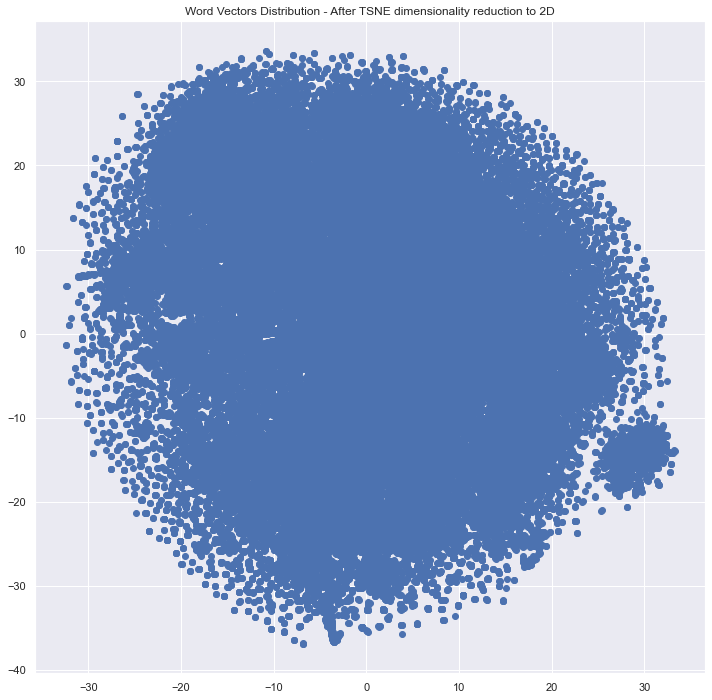

In [23]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set()


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(44)
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    # selected_indices = indices[:120]
    # for i in selected_indices:
    #     plt.annotate(labels[i], (x_vals[i], y_vals[i])) ## annotate on the plot 10 randomly chosen words
    plt.title('Word Vectors Distribution - After TSNE dimensionality reduction to 2D')
    # plt.savefig('word_vectors_distribution.png', bbox_inches='tight', facecolor='w')
        
    
x_vals, y_vals, labels = reduce_dimensions(model)
plot_with_matplotlib(x_vals, y_vals, labels)

Word: cybersecurity, Coords: 25.682109832763672, -1.5323050022125244
Word: ransomware, Coords: 25.583507537841797, -2.12795352935791
Word: threats, Coords: 28.658140182495117, -0.08697495609521866
Word: childlessness, Coords: -4.532100200653076, 0.14043447375297546
Word: dysfunctions, Coords: -6.6008782386779785, -3.670936107635498
Word: infertile, Coords: -4.84510612487793, 11.687073707580566
Word: couples, Coords: -4.793115139007568, 11.679988861083984
Word: imaging, Coords: -5.026052474975586, 16.639245986938477
Word: multispectral, Coords: -24.883712768554688, -9.016572952270508
Word: endoscope, Coords: -22.16045570373535, 19.4349422454834
Word: malaria, Coords: -8.530746459960938, 0.1506219506263733
Word: parasite, Coords: -18.47332000732422, -0.45092692971229553
Word: tourists, Coords: -8.065476417541504, 1.1652603149414062
Word: patient, Coords: -1.407575249671936, -1.6750065088272095
Word: credentials, Coords: 12.115683555603027, 2.113276720046997
Word: directories, Coords: 11.

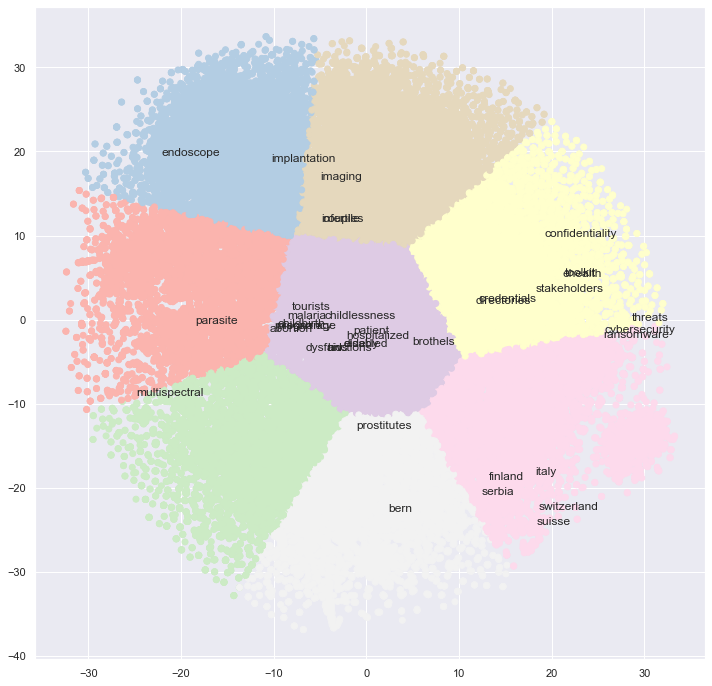

In [24]:
from sklearn.cluster import KMeans

words = ['cybersecurity', 'ransomware', 'threats', 'childlessness', 'dysfunctions', 
         'infertile', 'couples', 'imaging', 'multispectral', 'endoscope', 'malaria', 'parasite', 'tourists', 'patient', 'credentials', 'directories', 'confidentiality',
         'ehealth', 'toolkit', 'stakeholders', 'switzerland', 'bern', 'suisse', 'serbia', 'italy', 'finland', 'elderly', 'disabled', 'hospitalized',
         'pregnancy', 'childbirth', 'miscarriage', 'abortion', 'implantation', 'aids', 'hiv', 'prostitutes', 'brothels']
chosen_words_indices = [output_vectors.get_index(word) for word in words]

kmeans = KMeans(n_clusters = 8)
kmeans.fit(np.array([x_vals, y_vals]).T)
labels = kmeans.predict(np.array([x_vals, y_vals]).T)
word_labels = np.asarray(model.wv.index_to_key)

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals, c = labels, cmap = 'Pastel1', alpha=1.0)

centers = kmeans.cluster_centers_
for i in range(len(words)):
    word_key_index = chosen_words_indices[i]
    pos = (x_vals[word_key_index], y_vals[word_key_index])
        
    print('Word: {}, Coords: {}, {}'.format(words[i], x_vals[word_key_index], y_vals[word_key_index]))
    plt.annotate(words[i], xy=(x_vals[word_key_index], y_vals[word_key_index]))
plt.show()